# Hidden Markov Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Hidden Markov models (HMMs) are the flagship of the pomegranate package, in that most time is spent improving their implementation, and these improvements sometimes trickle down into the other algorithms. Lets delve into the features which pomegranate offers.

Hidden Markov models are a form of structured prediction method which extend general mixture models to sequences of data, where position in the sequence is relevant. If each point in this sequence is completely independent of the other points, then HMMs are not the right tools and GMMs (or more complicated Bayesian networks) may be a better tool.

The most common examples of HMMs come from bioinformatics and natural language processing. Since I am a bioinformatician, I will predominately use examples from bioinformatics.

## GMMs vs HMMs in the CG rich region example

Lets take the simplified example of CG island detection on a sequence of DNA. DNA is made up of the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. Specific organizations of these nucleotides encode enough information to build you, a human being. One simple region in the genome is called the 'CG' island, where the nucleotides 'C' and 'G' are enriched. Lets compare the predictions of a GMM with the predictions of a HMM, to both understand conceptually the differences between the two, and to see how easy it is to use pomegranate.

In [1]:
from pomegranate import *
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
seq = list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC')

d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State( d1, name='background' )
s2 = State( d2, name='CG island' )

gmm = GeneralMixtureModel( [d1, d2] )
hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.5 )
hmm.add_transition( s1, s2, 0.5 )
hmm.add_transition( s2, s1, 0.5 )
hmm.add_transition( s2, s2, 0.5 )
hmm.bake()

In [3]:
gmm_predictions = gmm.predict( np.array(seq) )
hmm_predictions = hmm.predict( seq )

print "sequence: {}".format( ''.join( seq ) )
print "gmm pred: {}".format( ''.join( map( str, gmm_predictions ) ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
gmm pred: 110100101010010111110111101011110100001011110001111
hmm pred: 001011010101101000001000010100001011110100001110000


Note: The HMM and GMM predictions may be the inverse of each other, because HMM states undergo a topological sort in order to properly handle silent states (more later), which can cause the order they were inserted into the model. 

Your first reaction may to say "But Jacob, you just said that HMMs and GMMs are different. Why shold I make a HMM when making a GMM is so easy?". 

My point in showing you this is that a dense HMM with equal probabilities between each state is ~equivalent~ to a GMM. However, this framework gives us great flexibility to add prior knowledge, whereas a GMM doesn't. If we look at the predictions, we see that it's bifurcating between "background" and "CG island" very quickly--in essence, calling every C or G a 'CG island'. This is not likely to be true. We know that CG islands have some As and Ts in them, and background sequence has Cs and Gs. We can change the transition probabilities to account for this, and prevent switching from occuring too rapidly.

In [4]:
hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.9 )
hmm.add_transition( s1, s2, 0.1 )
hmm.add_transition( s2, s1, 0.1 )
hmm.add_transition( s2, s2, 0.9 )
hmm.bake()

In [5]:
hmm_predictions = hmm.predict( seq )

print "sequence: {}".format( ''.join( seq ) )
print "gmm pred: {}".format( ''.join( map( str, gmm_predictions ) ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
gmm pred: 110100101010010111110111101011110100001011110001111
hmm pred: 111111111111111000000000000000011111111111111110000

hmm state 0: CG island
hmm state 1: background


This seems far more reasonable. There is a single CG island surrounded by background sequence, and something at the end. If we knew that CG islands cannot occur at the end of sequences, we need only modify the underlying structure of the HMM in order to say that the sequence must end from the background state.

In [6]:
hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.89 )
hmm.add_transition( s1, s2, 0.10 )
hmm.add_transition( s1, hmm.end, 0.01 )
hmm.add_transition( s2, s1, 0.1 )
hmm.add_transition( s2, s2, 0.9 )
hmm.bake()

In [7]:
hmm_predictions = hmm.predict( seq )

print "sequence: {}".format( ''.join( seq ) )
print "gmm pred: {}".format( ''.join( map( str, gmm_predictions ) ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
gmm pred: 110100101010010111110111101011110100001011110001111
hmm pred: 111111111111111000000000000000011111111111111111111

hmm state 0: CG island
hmm state 1: background


Looks like we managed to get rid of that pesky end (again, the numbers may have flipped, look at the indices). Modifying transition probabilities and using non-dense graphical structures are two major ways in which HMMs account for data in a sequence not being independent and identically distributed (i.i.d.). In fact, in most applications, the graphical structure of a HMM is very sparse. 

If we want a more probabilistic view of what's going on, we can get the probability of each symbol in the sequence being in each of the states in the model easily. This is useful to get a soft estimate of classification, which allows us to include confidence as well as prediction. Values close to 50-50 get masked when you make hard classifications, but this uncertainty can be passed to future applications if you use soft assignments. Each row in the matrix is one symbol in the sequence, and the columns correspond to the two states identified above (CG island or background).

In [8]:
print hmm.predict_proba( seq )

[[ 0.4827054   0.5172946 ]
 [ 0.42204064  0.57795936]
 [ 0.28598775  0.71401225]
 [ 0.25756456  0.74243544]
 [ 0.16040038  0.83959962]
 [ 0.13871983  0.86128017]
 [ 0.17217854  0.82782146]
 [ 0.14750165  0.85249835]
 [ 0.18021186  0.81978814]
 [ 0.15446181  0.84553819]
 [ 0.18788044  0.81211956]
 [ 0.16252887  0.83747113]
 [ 0.19841088  0.80158912]
 [ 0.32919701  0.67080299]
 [ 0.38366073  0.61633927]
 [ 0.58044619  0.41955381]
 [ 0.69075524  0.30924476]
 [ 0.74653183  0.25346817]
 [ 0.76392808  0.23607192]
 [ 0.7479817   0.2520183 ]
 [ 0.69407484  0.30592516]
 [ 0.74761829  0.25238171]
 [ 0.76321595  0.23678405]
 [ 0.74538467  0.25461533]
 [ 0.68896078  0.31103922]
 [ 0.57760471  0.42239529]
 [ 0.58391467  0.41608533]
 [ 0.53953778  0.46046222]
 [ 0.6030831   0.3969169 ]
 [ 0.61516689  0.38483311]
 [ 0.57928847  0.42071153]
 [ 0.48505793  0.51494207]
 [ 0.30518744  0.69481256]
 [ 0.25379428  0.74620572]
 [ 0.12610747  0.87389253]
 [ 0.08105965  0.91894035]
 [ 0.07637934  0.92362066]
 

There is a corresponding `hmm.predict_log_proba` method present if you want to get the log values. These are the emission probability values calculated by the forward backward algorithm, and can also be retrieved by calling `hmm.forward_backward( seq )`, which returns both the emission and the transition probability tables.

Lets take a look at these tables!

In [9]:
trans, ems = hmm.forward_backward( seq )
print trans

[[ 15.78100555   2.89559314   0.           0.        ]
 [  2.41288774  28.91051356   0.           1.        ]
 [  0.4827054    0.5172946    0.           0.        ]
 [  0.           0.           0.           0.        ]]


This is the transition table, which has the soft count of the number of transitions across an edge in the model given a single sequence. It is a square matrix of size equal to the number of states (including start and end state), with number of transitions from (row_id) to (column_id). This is exemplified by the 1.0 in the first row, indicating that there is one transition from background state to the end state, as that's the only way to reach the end state. However, the third (or fourth, depending on ordering) row is the transitions from the start state, and it only slightly favors the background state. These counts are not normalized to the length of the input sequence, but can easily be done so by dividing by row sums, column sums, or entire table sums, depending on your application.

A possible reason not to normalize is to run several sequences through and add up their tables, because normalizing in the end and extracting some domain knowledge. It is extremely useful in practice. For example, we can see that there is an expectation of 2.8956 transitions from CG island to background, and 2.4 from background to CG island. This could be used to infer that there are ~2-3 edges, which makes sense if you consider that the start and end of the sequence seem like they might be part of the CG island states except for the strict transition probabilities used (look at the first few rows of the emission table above.)

We've been using the forward backward algorithm and maximum a posteriori for decoding thus far, however maximum a posteriori decoding has the side effect that it is possible that it predicts impossible sequences in some edge cases. An alternative is Viterbi decoding, which at each step takes the most likely path, instead of sum of all paths, to produce hard assignments.

In [10]:
hmm_predictions = hmm.predict( seq, algorithm='viterbi' )[1:-1]

print "sequence: {}".format( ''.join( seq ) )
print "gmm pred: {}".format( ''.join( map( str, gmm_predictions ) ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
gmm pred: 110100101010010111110111101011110100001011110001111
hmm pred: 111111111111111111111111111111111111111111111111111

hmm state 0: CG island
hmm state 1: background


We see here a case in which it does not do too well. The Viterbi path can be more conservative in its transitions due to the hard assignments it makes. In essence, if multiple possibile paths are possible at a given point, it takes the most likely path, even if the sum of all other paths is greater than the sum of that path. In problems with a lower signal to noise ratio, this can mask the signal. As a side note, we can use the following to get the maximum a posteriori and Viterbi paths:

In [11]:
v_logp, v_seq = hmm.viterbi( seq )
m_logp, m_seq = hmm.maximum_a_posteriori( seq )

The sequence predicted is a tuple of (state id, state object) for every state in the predicted path. The predict method simply takes the state ids from this path and returns those as an array. 

## Sequence Alignment

Lets move on to a more complicated structure, that of a profile HMM. A profile HMM is used to align a sequence to a reference 'profile', where the reference profile can either be a single sequence, or an alignment of many sequences (such as a reference genome). In essence, this profile has a 'match' state for every position in the reference profile, and 'insert' state, and a 'delete' state. The insert state allows the external sequence to have an insertion into the sequence without throwing off the entire alignment, such as the following:

`ACCG : Sequence` <br>
`|| |` <br>
`AC-G : Reference`

or a deletion, which is the opposite:

`A-G : Sequence` <br>
`| |` <br>
`ACG : Reference`

The bars in the middle refer to a perfect match, whereas the lack of a bar means either a deletion/insertion, or a mismatch. A mismatch is where two positions are aligned together, but do not match. This models the biological phenomena of mutation, where one nucleotide can convert to another over time. It is usually more likely in biological sequences that this type of mutation occurs than that the nucleotide was deleted from the sequence (shifting all nucleotides over by one) and then another was inserted at the exact location (moving all nucleotides over again). Since we are using a probabilistic model, we get to define these probabilities through the use of distributions! If we want to model mismatches, we can just set our 'match' state to have an appropriate distribution with non-zero probabilities over mismatches. 

Lets now create a three nucleotide profile HMM, which models the sequence 'ACT'. We will fuzz this a little bit in the match states, pretending to have some prior information about what mutations occur at each position. If you don't have any information, setting a uniform, small, value over the other values is usually okay.

In [12]:
model = HiddenMarkovModel( "Global Alignment")

# Define the distribution for insertions
i_d = DiscreteDistribution( { 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 } )

# Create the insert states
i0 = State( i_d, name="I0" )
i1 = State( i_d, name="I1" )
i2 = State( i_d, name="I2" )
i3 = State( i_d, name="I3" )

# Create the match states
m1 = State( DiscreteDistribution({ "A": 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02 }) , name="M1" )
m2 = State( DiscreteDistribution({ "A": 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004 }) , name="M2" )
m3 = State( DiscreteDistribution({ "A": 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97 }) , name="M3" )

# Create the delete states
d1 = State( None, name="D1" )
d2 = State( None, name="D2" )
d3 = State( None, name="D3" )

# Add all the states to the model
model.add_states( [i0, i1, i2, i3, m1, m2, m3, d1, d2, d3 ] )

# Create transitions from match states
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )
model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )
model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )

# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

# Call bake to finalize the structure of the model.
model.bake()

Now lets try to align some sequences to it and see what happens!

In [13]:
for sequence in map( list, ('ACT', 'GGC', 'GAT', 'ACC') ):
    logp, path = model.viterbi( sequence )
    print "Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) )

Sequence: 'ACT'  -- Log Probability: -0.513244900357 -- Path: M1 M2 M3
Sequence: 'GGC'  -- Log Probability: -11.0481012413 -- Path: I0 I0 D1 M2 D3
Sequence: 'GAT'  -- Log Probability: -9.12551967402 -- Path: I0 M1 D2 M3
Sequence: 'ACC'  -- Log Probability: -5.08795587886 -- Path: M1 M2 M3


The first and last sequence are entirely matches, meaning that it thinks the most likely alignment between the profile ACT and ACT is A-A, C-C, and T-T, which makes sense, and the most likely alignment between ACT and ACC is A-A, C-C, and T-C, which includes a mismatch. Essentially, it's more likely that there's a T-C mismatch at the end then that there was a deletion of a T at the end of the sequence, and a separate insertion of a C.

The two middle sequences don't match very well, as expected! G's are not very likely in this profile at all. It predicts that the two G's are inserts, and that the C matches the C in the profile, before hitting the delete state because it can't emit a T. The third sequence thinks that the G is an insert, as expected, and then aligns the A and T in the sequence to the A and T in the master sequence, missing the middle C in the profile.

By using deletes, we can handle other sequences which are shorter than three characters. Lets look at some more sequences of different lengths.

In [14]:
for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print "Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) )

Sequence: 'A'  -- Log Probability: -5.40618101242 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.8868199358 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.62447187905 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.64488075068 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.6743329646 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.3938248352 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440175 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.9034517961 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.4516996541 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


Again, more of the same expected. You'll notice most of the use of insertion states are at I0, because most of the insertions are at the beginning of the sequence. It's more probable to simply stay in I0 at the beginning instead of go from I0 to D1 to I1, or going to another insert state along there. You'll see other insert states used when insertions occur in other places in the sequence, like 'ATTT' and 'ACGTG'.
Now that we have the path, we need to convert it into an alignment, which is significantly more informative to look at.

In [15]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    x, y = path_to_alignment( 'ACT', ''.join(sequence), path )
    
    print "Sequence: {}, Log Probability: {}".format( ''.join(sequence), logp )
    print "{}\n{}".format( x, y )
    print

Sequence: A, Log Probability: -5.40618101242
ACT
A--

Sequence: GA, Log Probability: -10.8868199358
-ACT
GA--

Sequence: AC, Log Probability: -3.62447187905
ACT
AC-

Sequence: AT, Log Probability: -3.64488075068
ACT
A-T

Sequence: ATCC, Log Probability: -10.6743329646
ACT--
A-TCC

Sequence: ACGTG, Log Probability: -10.3938248352
AC---T
ACGTG-

Sequence: ATTT, Log Probability: -8.67126440175
A--CT
ATT-T

Sequence: TACCCTC, Log Probability: -16.9034517961
----ACT-
TACC-CTC

Sequence: TGTCAACACT, Log Probability: -16.4516996541
-------ACT
TGTCAACACT



In addition to getting this alignment, we can do some interesting things with this model! Lets score every sequence of length 5 of less and see what the distribution looks like.

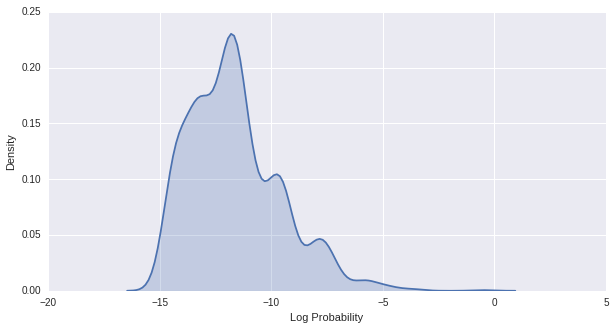

In [16]:
import itertools
import seaborn as sns

sequences = reduce( lambda x, y: x+y, [[ seq for seq in it.product( 'ACGT', repeat=i ) ] for i in xrange( 1,6 )] )
scores = map( model.log_probability, sequences )

plt.figure( figsize=(10,5) )
sns.kdeplot( numpy.array( scores ), shade=True )
plt.ylabel('Density')
plt.xlabel('Log Probability')
plt.show()

## Training Hidden Markov Models

There are two main algorithms for training hidden Markov models-- Baum Welch (structured version of Expectation Maximization), and Viterbi training. Since we don't start off with labels on the data, these are both unsupervised training algorithms. In order to assign labels, Baum Welch uses EM to assign soft labels (weights in this case) to each point belonging to each state, and then using weighted MLE estimates to update the distributions. Viterbi assigns hard labels to each observation using the Viterbi algorithm, and then updates the distributions based on these hard labels.

pomegranate is extremely well featured when it comes to regularization methods for training, supporting tied emissions and edges, edge and emission inertia, freezing nodes or edges, edge pseudocounts, and multithreaded training. Lets look at some examples of the following:

### Tied Emissions

Sometimes we want to say that multiple states model the same phenomena, but are simply at different points in the graph because we are utilizing complicated edge structure. An example is in the example of the global alignment HMM we saw. All insert states represent the same phenomena, which is nature randomly inserting a nucleotide, and this probability should be the same regardless of position. However, we can't simply have a single insert state, or we'd be allowed to transition from any match state to any other match state.

You can tie emissions together simply by passing the same distribution object to multiple states. That's it.

In [17]:
d = NormalDistribution( 5, 2 )

s1 = State( d, name="Tied1" )
s2 = State( d, name="Tied2" )

s3 = State( NormalDistribution( 5, 2 ), name="NotTied1" )
s4 = State( NormalDistribution( 5, 2 ), name="NotTied2" )

You have now indicated that these two states are tied, and when training, the weights of all points going to s2 will be added to the weights of all points going to s1 when updating d. As a side note, this is implemented in a computationally efficient manner such that d will only be updated once, not twice (but giving the same result). s3 and s4 are not tied together, because while they have the same distribution, it is not the same python object.

### Tied Edges

Edges can be tied together for the same reason. If you have a modular structure to your HMM, perhaps you believe this repeating structure doesn't (or shouldn't) have a position specific edge structure. You can do this simply by adding a group when you add transitions.

In [18]:
model = HiddenMarkovModel()
model.add_states( [s1, s2] )
model.add_transition( model.start, s1, 0.5, group='a' )
model.add_transition( model.start, s2, 0.5, group='b' )
model.add_transition( s1, s2, 0.5, group='a' )
model.add_transition( s2, s1, 0.5, group='b' )
model.bake()

The above model doesn't necessarily make sense, but it shows how simple it is to tie edges as well. You can go ahead and train normally from this point, without needing to change any code.

### Inertia

The next options are inertia on edges or on distributions. This simply means that you update your parameters as (previous_parameter * inertia) + (new_parameter * (1-inertia) ). It is a way to prevent your updates from overfitting immediately. You can specify this in the train function using either `edge_inertia` or `distribution_inertia`. These default to 0, with 1 being the maximum, meaning that you don't update based on new evidence, the same as freezing a distribution or the edges.

In [19]:
model.train( [[5, 2, 3, 4], [5, 7, 2, 3, 5]], distribution_inertia=0.3, edge_inertia=0.25 )

Training improvement: 1.42546236476
Training improvement: 0.150770454545
Training improvement: 0.0135693409091
Training improvement: 0.00122124068182
Training improvement: 0.000109911661365
Training improvement: 9.89204952262e-06
Training improvement: 8.90284457711e-07
Training improvement: 8.01255986005e-08
Training improvement: 7.21130533066e-09
Training improvement: 6.49016840271e-10
Total Training Improvement: 1.59114418288


1.5911441828758832

### Pseudocounts

Another way of regularizing your model is to add pseudocounts to your edges (which have non-zero probabilities). When updating your edges in the future, you add this pseudocount to the count of transitions across that edge in the future. This gives a more Bayesian estimate of the edge probability, and is useful if you have a large model and don't expect to cross most of the edges with your training data. An example might be a complicated profile HMM, where you don't expect to see deletes or inserts at all in your training data, but don't want to change from the default values.

In pomegranate, pseudocounts default to the initial probabilities, so that if you don't see data, the edge values simply aren't updated. You can define both edge specific pseudocounts when you define the transition. When you train, you must define `use_pseudocount=True`.

In [20]:
s1 = State( NormalDistribution( 3, 1 ), name="s1" )
s2 = State( NormalDistribution( 6, 2 ), name="s2" )

model = HiddenMarkovModel()
model.add_states( [s1, s2] )
model.add_transition( model.start, s1, 0.5, pseudocount=4.2 )
model.add_transition( model.start, s2, 0.5, pseudocount=1.3 )
model.add_transition( s1, s2, 0.5, pseudocount=5.2 )
model.add_transition( s2, s1, 0.5, pseudocount=0.9 )
model.bake()
model.train( [[5, 2, 3, 4], [5, 7, 2, 3, 5]], max_iterations=5, use_pseudocount=True )

Training improvement: 3.42346975202
Training improvement: 0.217661114963
Training improvement: 0.031578660226
Training improvement: 0.00659919633505
Training improvement: 0.00190080724972
Total Training Improvement: 3.6812095308


3.6812095307959467

The other way is to put a blanket pseudocount on all edges.

In [21]:
s1 = State( NormalDistribution( 3, 1 ), name="s1" )
s2 = State( NormalDistribution( 6, 2 ), name="s2" )

model = HiddenMarkovModel()
model.add_states( [s1, s2] )
model.add_transition( model.start, s1, 0.5 )
model.add_transition( model.start, s2, 0.5 )
model.add_transition( s1, s2, 0.5 )
model.add_transition( s2, s1, 0.5 )
model.bake()
model.train( [[5, 2, 3, 4], [5, 7, 2, 3, 5]], max_iterations=5, transition_pseudocount=20, use_pseudocount=True )

Training improvement: 3.32270811471
Training improvement: 0.160909798897
Training improvement: 0.0329521413094
Training improvement: 0.00953914051447
Training improvement: 0.00315874050675
Total Training Improvement: 3.52926793594


3.5292679359352164

We can see that there isn't as much of an improvement. This is part of regularization, though. We sacrifice fitting the data exactly in order for our model to generalize better to future data. The majority of the training improvement is likely coming from the emissions better fitting the data, though.

### Multithreaded Training

Since pomegranate is implemented in cython, the majority of functions are written with the GIL released. A benefit of doing this is that we can use multithreading in order to make some computationally intensive tasks take less time. However, a downside is that python doesn't play nicely with multithreading, and so there are some cases where training using multithreading can make your model training take significantly longer. I investigate this in an early multithreading pull request <a href="https://github.com/jmschrei/pomegranate/pull/30">here</a>. Things have improved since then, but the gist is that if you have a small model (less than 15 states), it may be detrimental, but the larger your model is, the more it scales towards getting a speed improvement exactly the number of threads you use. You can specify multithreading using the `n_jobs` keyword. All structures in pomegranate are thread safe, so you don't need to worry about race conditions.

In [22]:
s1 = State( NormalDistribution( 3, 1 ), name="s1" )
s2 = State( NormalDistribution( 6, 2 ), name="s2" )

model = HiddenMarkovModel()
model.add_states( [s1, s2] )
model.add_transition( model.start, s1, 0.5 )
model.add_transition( model.start, s2, 0.5 )
model.add_transition( s1, s2, 0.5 )
model.add_transition( s2, s1, 0.5 )
model.bake()
model.train( [[5, 2, 3, 4, 7, 3, 6, 3, 5, 2, 4], [5, 7, 2, 3, 5, 1, 3, 5, 6, 2]], max_iterations=5 )

Training improvement: 6.91636682627
Training improvement: 0.807997703056
Training improvement: 0.225451019863
Training improvement: 0.0142426402922
Training improvement: 0.000547351061158
Total Training Improvement: 7.96460554054


7.964605540540248

In [23]:
s1 = State( NormalDistribution( 3, 1 ), name="s1" )
s2 = State( NormalDistribution( 6, 2 ), name="s2" )

model = HiddenMarkovModel()
model.add_states( [s1, s2] )
model.add_transition( model.start, s1, 0.5 )
model.add_transition( model.start, s2, 0.5 )
model.add_transition( s1, s2, 0.5 )
model.add_transition( s2, s1, 0.5 )
model.bake()
model.train( [[5, 2, 3, 4, 7, 3, 6, 3, 5, 2, 4], [5, 7, 2, 3, 5, 1, 3, 5, 6, 2]], max_iterations=5, n_jobs=4 )

Training improvement: 6.91636682627
Training improvement: 0.807997703056
Training improvement: 0.225451019863
Training improvement: 0.0142426402922
Training improvement: 0.000547351061158
Total Training Improvement: 7.96460554054


7.964605540540248

## Serialization

General Mixture Models support serialization to JSONs using `to_json()` and `from_json( json )`. This is useful is you want to train a GMM on large amounts of data, taking a significant amount of time, and then use this model in the future without having to repeat this computationally intensive step (sounds familiar by now). Lets look at the original CG island model, since it's significantly smaller.

In [24]:
seq = list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC')

d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State( d1, name='background' )
s2 = State( d2, name='CG island' )

hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.5 )
hmm.add_transition( s1, s2, 0.5 )
hmm.add_transition( s2, s1, 0.5 )
hmm.add_transition( s2, s2, 0.5 )
hmm.bake()

In [25]:
print hmm.to_json()

{
    "end" : "{\n    \"distribution\" : null,\n    \"class\" : \"State\",\n    \"weight\" : 1.0,\n    \"name\" : \"None-end\"\n}",
    "name" : "None",
    "distribution ties" : [],
    "silent_index" : 2,
    "end_index" : 2,
    "states" : [
        "{\n    \"distribution\" : \"{\\n    \\\"frozen\\\" : false,\\n    \\\"class\\\" : \\\"Distribution\\\",\\n    \\\"parameters\\\" : [\\n        {\\n            \\\"A\\\" : 0.1,\\n            \\\"C\\\" : 0.4,\\n            \\\"T\\\" : 0.1,\\n            \\\"G\\\" : 0.4\\n        }\\n    ],\\n    \\\"name\\\" : \\\"DiscreteDistribution\\\"\\n}\",\n    \"class\" : \"State\",\n    \"weight\" : 1.0,\n    \"name\" : \"CG island\"\n}",
        "{\n    \"distribution\" : \"{\\n    \\\"frozen\\\" : false,\\n    \\\"class\\\" : \\\"Distribution\\\",\\n    \\\"parameters\\\" : [\\n        {\\n            \\\"A\\\" : 0.25,\\n            \\\"C\\\" : 0.25,\\n            \\\"T\\\" : 0.25,\\n            \\\"G\\\" : 0.25\\n        }\\n    ],\\n    \\\"na

In [26]:
seq = list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC')
print hmm.log_probability( seq )

-69.7012190974


In [27]:
hmm_2 = HiddenMarkovModel.from_json( hmm.to_json() )
print hmm_2.log_probability( seq )

-69.7012190974
